In [57]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

abs_data_path = "data/stats"

### Load a dataframe

In [58]:
files_tree = {}

for date_folder in os.listdir(abs_data_path):
    if date_folder.startswith("."):
        continue

    for log_file in os.listdir(abs_data_path+"/"+date_folder):
        if log_file[:-4] not in files_tree:
            files_tree[log_file[:-4]] = []

        files_tree[log_file[:-4]].append(abs_data_path+"/"+date_folder+"/"+log_file)

files_flat = []
for con in files_tree:
    files_flat += files_tree[con]

files_flat = set(files_flat)



In [59]:
csv_headers = ["timestamp", "incoming_rate_avg", "outgoing_rate_avg", "incoming_rate_max", "outgoing_rate_max"]
col_names = csv_headers + ["collection_timestamp", "src_host", "dst_host"]

df = pd.DataFrame(columns=col_names)

dfs = []

for date_folder in os.listdir(abs_data_path):

    if date_folder.startswith("."):
        continue

    collection_dir_path = abs_data_path + "/" + date_folder

    collection_times = []
    for file_path in os.listdir(collection_dir_path):
        data_file_path = collection_dir_path + "/" + file_path

        with open(data_file_path) as fil:
            firstline = fil.readline().rstrip()
            
        collection_times.append(firstline.split()[0])

        _df = pd.read_csv(data_file_path, sep=" ", names=csv_headers, skiprows=[0])

        src_host = data_file_path.split("/")[-1].split("-")[0]
        dst_host = data_file_path.split("/")[-1].split("-")[1][:-4]

        _df["collection_timestamp"] = max(set(collection_times), key = collection_times.count)
        _df["src_host"] = src_host
        _df["dst_host"] = dst_host

    dfs.append(_df[1:])

df = pd.concat(dfs, ignore_index=True)


In [60]:
df.timestamp = pd.to_datetime(df.timestamp, unit="s")
df.collection_timestamp = pd.to_datetime(df.collection_timestamp, unit="s")
df = df.astype({"incoming_rate_max": np.int64, "outgoing_rate_max": np.int64, "src_host": str, "dst_host": str})

### Collection time analysis

In [61]:
print(f"Num of unique collections: {len(df.collection_timestamp.unique())}")
print(f"Num of collection files: {len([ el for el in list(os.listdir(abs_data_path)) if not el.startswith('.') ])}")

collection_days = (df.collection_timestamp.max() - df.collection_timestamp.min())
collection_start = df.collection_timestamp.min()
collection_end = df.collection_timestamp.max()
print(f"Data collected for {collection_days}, starting from {collection_start} to {collection_end}")

df.head(5)

Num of unique collections: 271
Num of collection files: 271
Data collected for 527 days 06:30:01, starting from 2020-12-13 15:25:03 to 2022-05-24 21:55:04


,timestamp,incoming_rate_avg,outgoing_rate_avg,incoming_rate_max,outgoing_rate_max,collection_timestamp,src_host,dst_host
0,2022-04-06 21:50:04,6084007,1451364,6084007,1451364,2022-04-06 21:55:03,b1rtr,uci
1,2022-04-06 21:50:00,6075012,1452736,6084007,1588601,2022-04-06 21:55:03,b1rtr,uci
2,2022-04-06 21:45:00,5186284,1587979,5314584,1588601,2022-04-06 21:55:03,b1rtr,uci
3,2022-04-06 21:40:00,5316768,1563045,5533017,3647812,2022-04-06 21:55:03,b1rtr,uci
4,2022-04-06 21:35:00,5534878,3653515,5719153,4218132,2022-04-06 21:55:03,b1rtr,uci


In [98]:
for collection in df.collection_timestamp.unique()[:5]:
    _df = df.where(df.collection_timestamp == collection)
    print(_df.timestamp.max() - _df.timestamp.min())

795 days 21:50:04
795 days 22:50:04
795 days 22:50:03
795 days 21:50:04
795 days 22:50:04


In [8]:
_diff = df \
        [df.src_host == "b1rtr"][df.dst_host == "uci"] \
        [df.collection_timestamp == df[:1].collection_timestamp.to_numpy()[0]] \
        .shift(periods=1).timestamp - \
        df[df.src_host == "b1rtr"][df.dst_host == "uci"]\
        [df.collection_timestamp == df[:1].collection_timestamp.to_numpy()[0]] \
        .timestamp

In [31]:
np_diff = _diff.to_numpy(dtype='datetime64[s]')[3:]

In [51]:
_diff.to_numpy(dtype=np.int64)

array([-9223372036854775808,           4000000000,         300000000000,
       ...,       86400000000000,       86400000000000,
             86400000000000])

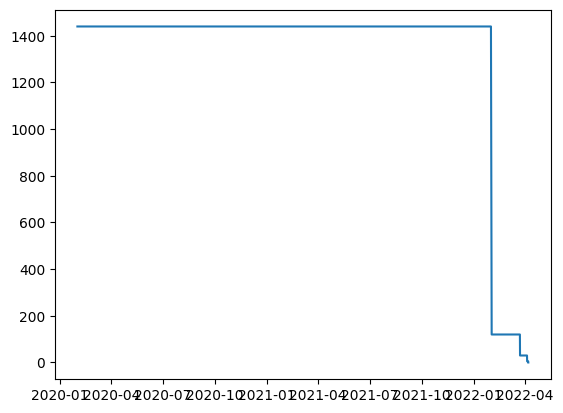

In [55]:
plt.plot(df[df.src_host == "b1rtr"][df.dst_host == "uci"][df.collection_timestamp == df[:1].collection_timestamp.to_numpy()[0]].timestamp[1:], _diff[1:].to_numpy(dtype=np.int64)/(1000000000*60))

2535
2535 2535


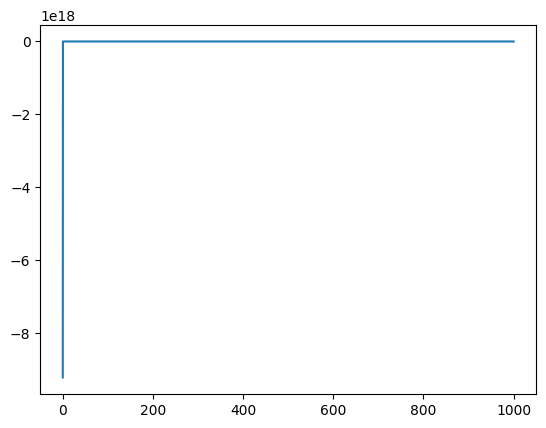

In [22]:
_np_diff = _diff.to_numpy(dtype=np.int64)
print(len(_np_diff))
linn = np.linspace(0, 1000, num=len(_np_diff))
print(len(linn), len(_np_diff))
_np_diff.sort()
plt.plot(linn, _np_diff)

### Wierd code, mostly tests

In [12]:
first_best_file = files_tree['b6rtr-b1'][0]
first_one = '/Users/nick/Dev/magisterka/data/stats/2020-12-15_00/b6rtr-b1.log'
middle_one = '/Users/nick/Dev/magisterka/data/stats/2021-06-07_00/b6rtr-b1.log'
last_one = '/Users/nick/Dev/magisterka/data/stats/2022-05-25_00/b6rtr-b1.log'

headers = ["timestamp", "incoming_rate_avg", "outgoing_rate_avg", "incoming_rate_max", "outgoing_rate_max"]
data_first = pd.read_csv(first_one, sep=" ", names=headers, skiprows=[0])
data_middle = pd.read_csv(middle_one, sep=" ", names=headers, skiprows=[0])
data_last = pd.read_csv(last_one, sep=" ", names=headers, skiprows=[0])

data_first.timestamp = pd.to_datetime(data_first.timestamp, unit="s")
data_last.timestamp = pd.to_datetime(data_last.timestamp, unit="s")
data_middle.timestamp = pd.to_datetime(data_middle.timestamp, unit="s")

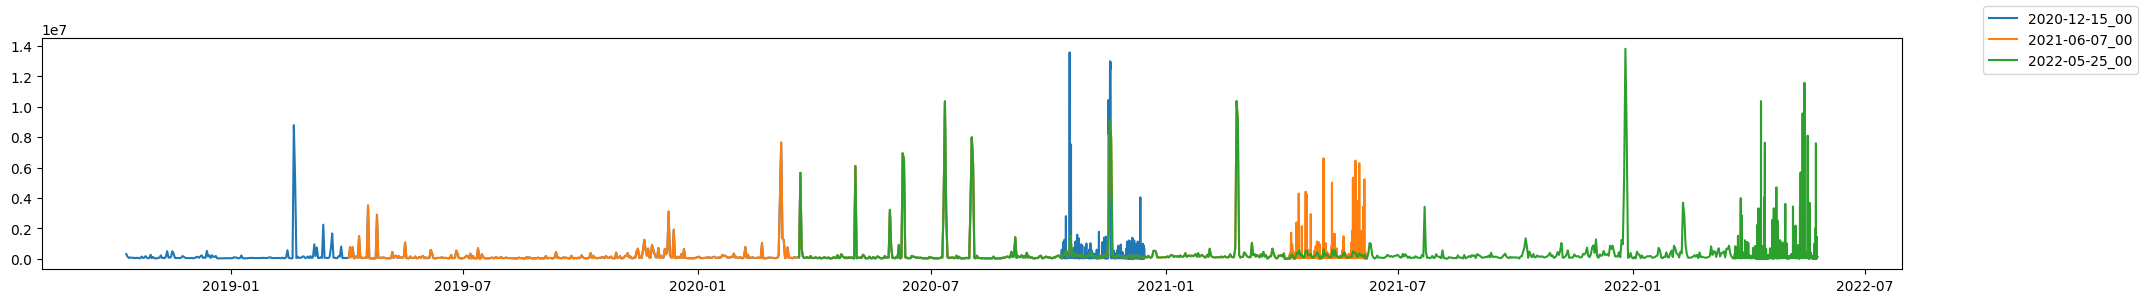

In [76]:

fig = plt.figure(figsize=(24, 3))
plt.plot(data_first.timestamp, data_first.incoming_rate_avg, label="2020-12-15_00")
plt.plot(data_middle.timestamp, data_middle.incoming_rate_avg, label="2021-06-07_00")
plt.plot(data_last.timestamp, data_last.incoming_rate_avg, label="2022-05-25_00")
fig.legend()

# Visual
* Delta histogram
* Delta time series graph
* Aggregation level showed with colors 
* Use 'gggraph' for graph visualization

,timestamp,incoming_rate_avg,outgoing_rate_avg,incoming_rate_max,outgoing_rate_max
2526,2020-02-10,39046,1369561,430498,7599423
2527,2020-02-09,266112,1647499,12293748,13941338
2528,2020-02-08,53696,1707453,326168,9807262
2529,2020-02-07,775300,1381194,12410580,2424313
2530,2020-02-06,158163,2138892,3164670,14096754
2531,2020-02-05,36469,1477200,687731,11279413
2532,2020-02-04,45295,1334651,863368,2564549
2533,2020-02-03,118429,1381926,2297737,2555259
2534,2020-02-02,63373,1145461,870891,2590365
2535,2020-02-01,54196,1274334,1690700,2238581


In [48]:
(1539216000 - 1539129600)/3600

24.0